# Driven Data - Richter's Predictor: Modeling Earthquake Damage

In this notebook, I explore a dataset from the [DrivenData competition](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/) focused on predicting the damage levels sustained by buildings during the 2015 Gorkha earthquake in Nepal. This catastrophic event resulted in widespread destruction, and the extensively collected data offers a comprehensive look at the impact. The dataset, one of the largest post-disaster collections ever assembled, includes critical information on the buildings' structure, household conditions, and socio-economic-demographic statistics. The objective is to predict the damage_grade—an ordinal variable indicating the severity of the damage, categorized into three grades: low damage (1), medium damage (2), and complete destruction (3). The dataset comprises 39 columns, with building_id serving as a unique identifier and the remaining 38 features detailing various aspects of the buildings.

_This submission placed in the 32nd position on the leaderboard (DSIF13), ranking within the top 1.5% of [submissions](https://www.drivendata.org/competitions/57/nepal-earthquake/leaderboard/)._

In [1]:
# Imports
import os
import re
import time
from joblib import parallel_backend
import cupy as cp
import pickle
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, pairwise_distances
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, coo_matrix
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb
import catboost as cb # Requires numpy < 2.0.0
import lightgbm as lgb

import numba

import warnings
warnings.filterwarnings("ignore")

/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Table of Contents

1. [Approach](#Approach)
2. [Data](#Data)
3. [Helpers](#Helpers)
4. [AutoEncoding Geographical Features](#AutoEncoding-Geographical-Features)
5. [CatBoost Classifier](#CatBoost-Classifier)
    i. [Vanilla CatBoost - no geo-encoding](#Vanilla-CatBoost---no-geo-encoding)
   ii. [Catboost with geo-encoding](#Catboost-with-geo-encoding)
7. [XGBoost](#XGBoost)
8. [LightGBM](#LightGBM)
9. [Ensemble](#Ensemble)
10. [Submission](#Submission-File)
11. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Approach

__Ensembling GBMs:__

In this project, Gradient Boosting Machines (GBMs) are employed to predict building damage, utilizing classifier variants of these GBMs. Specifically, XGBoost, CatBoost, and LightGBM are trained on the dataset. Small perturbations are introduced during model construction to generate multiple versions of these models. An ensemble approach is then applied, where the mode of the predicted damage grades is used as the final prediction.

__Auto-encoder to extract latent geographical relationships:__

The dataset includes geographical features encoded hierarchically as integers. The top geographical feature has 30 possible values, while the middle and bottom features have 1,427 and 12,567 possible values, respectively. Aside from the hierarchy, there is no indication of proximity or relationships between the different geographical encodings within each layer. For an earthquake-related problem, buildings in close proximity are likely to experience similar levels of damage. In this project, an autoencoder is used to construct a representation of these geographical proximities, training on other features (e.g. building characteristics) in the dataset as well as the target variables. Hyperparameter tuning is performed carefully to avoid inadvertently using labels from the validation/test set during training. The resulting latent variables are extracted for model training.

## Data

As shown below, the dataset consists of:
1. Hierarchical geographical features represented by `geo_level_1_id`,`geo_level_2_id`,`geo_level_3_id`;
2. A few numerical features, namely `count_floors_pre_eq`, `age`, `area_percentage`, `height_percentage`, `count_families`;
3. A multitude of categorical features; and
4. The target `damage_grade`, an ordinal variable with a value of either 1, 2 or 3.

In [2]:
# Loading provided train and prediction datasets. Prediction dataset refers to the unlabelled dataset, to be predicted on and submitted
datapath = './data/'
df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

# Feature groups
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']


df_train_features_raw.sample(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
309641,3,574,3150,3,40,5,7,t,r,n,...,0,0,0,0,0,0,0,0,0,0
470579,26,39,9133,2,0,19,7,t,i,x,...,0,0,0,0,0,0,0,0,0,0
110391,22,171,10384,1,5,7,3,t,u,n,...,0,0,0,0,0,0,0,0,0,0
498463,11,131,5997,2,30,13,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1001239,6,376,10236,2,50,8,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0


The plots below provide a quick overview to the distribution of `damage_grade` with different features. Note the large number of categorical features given by the barplots.

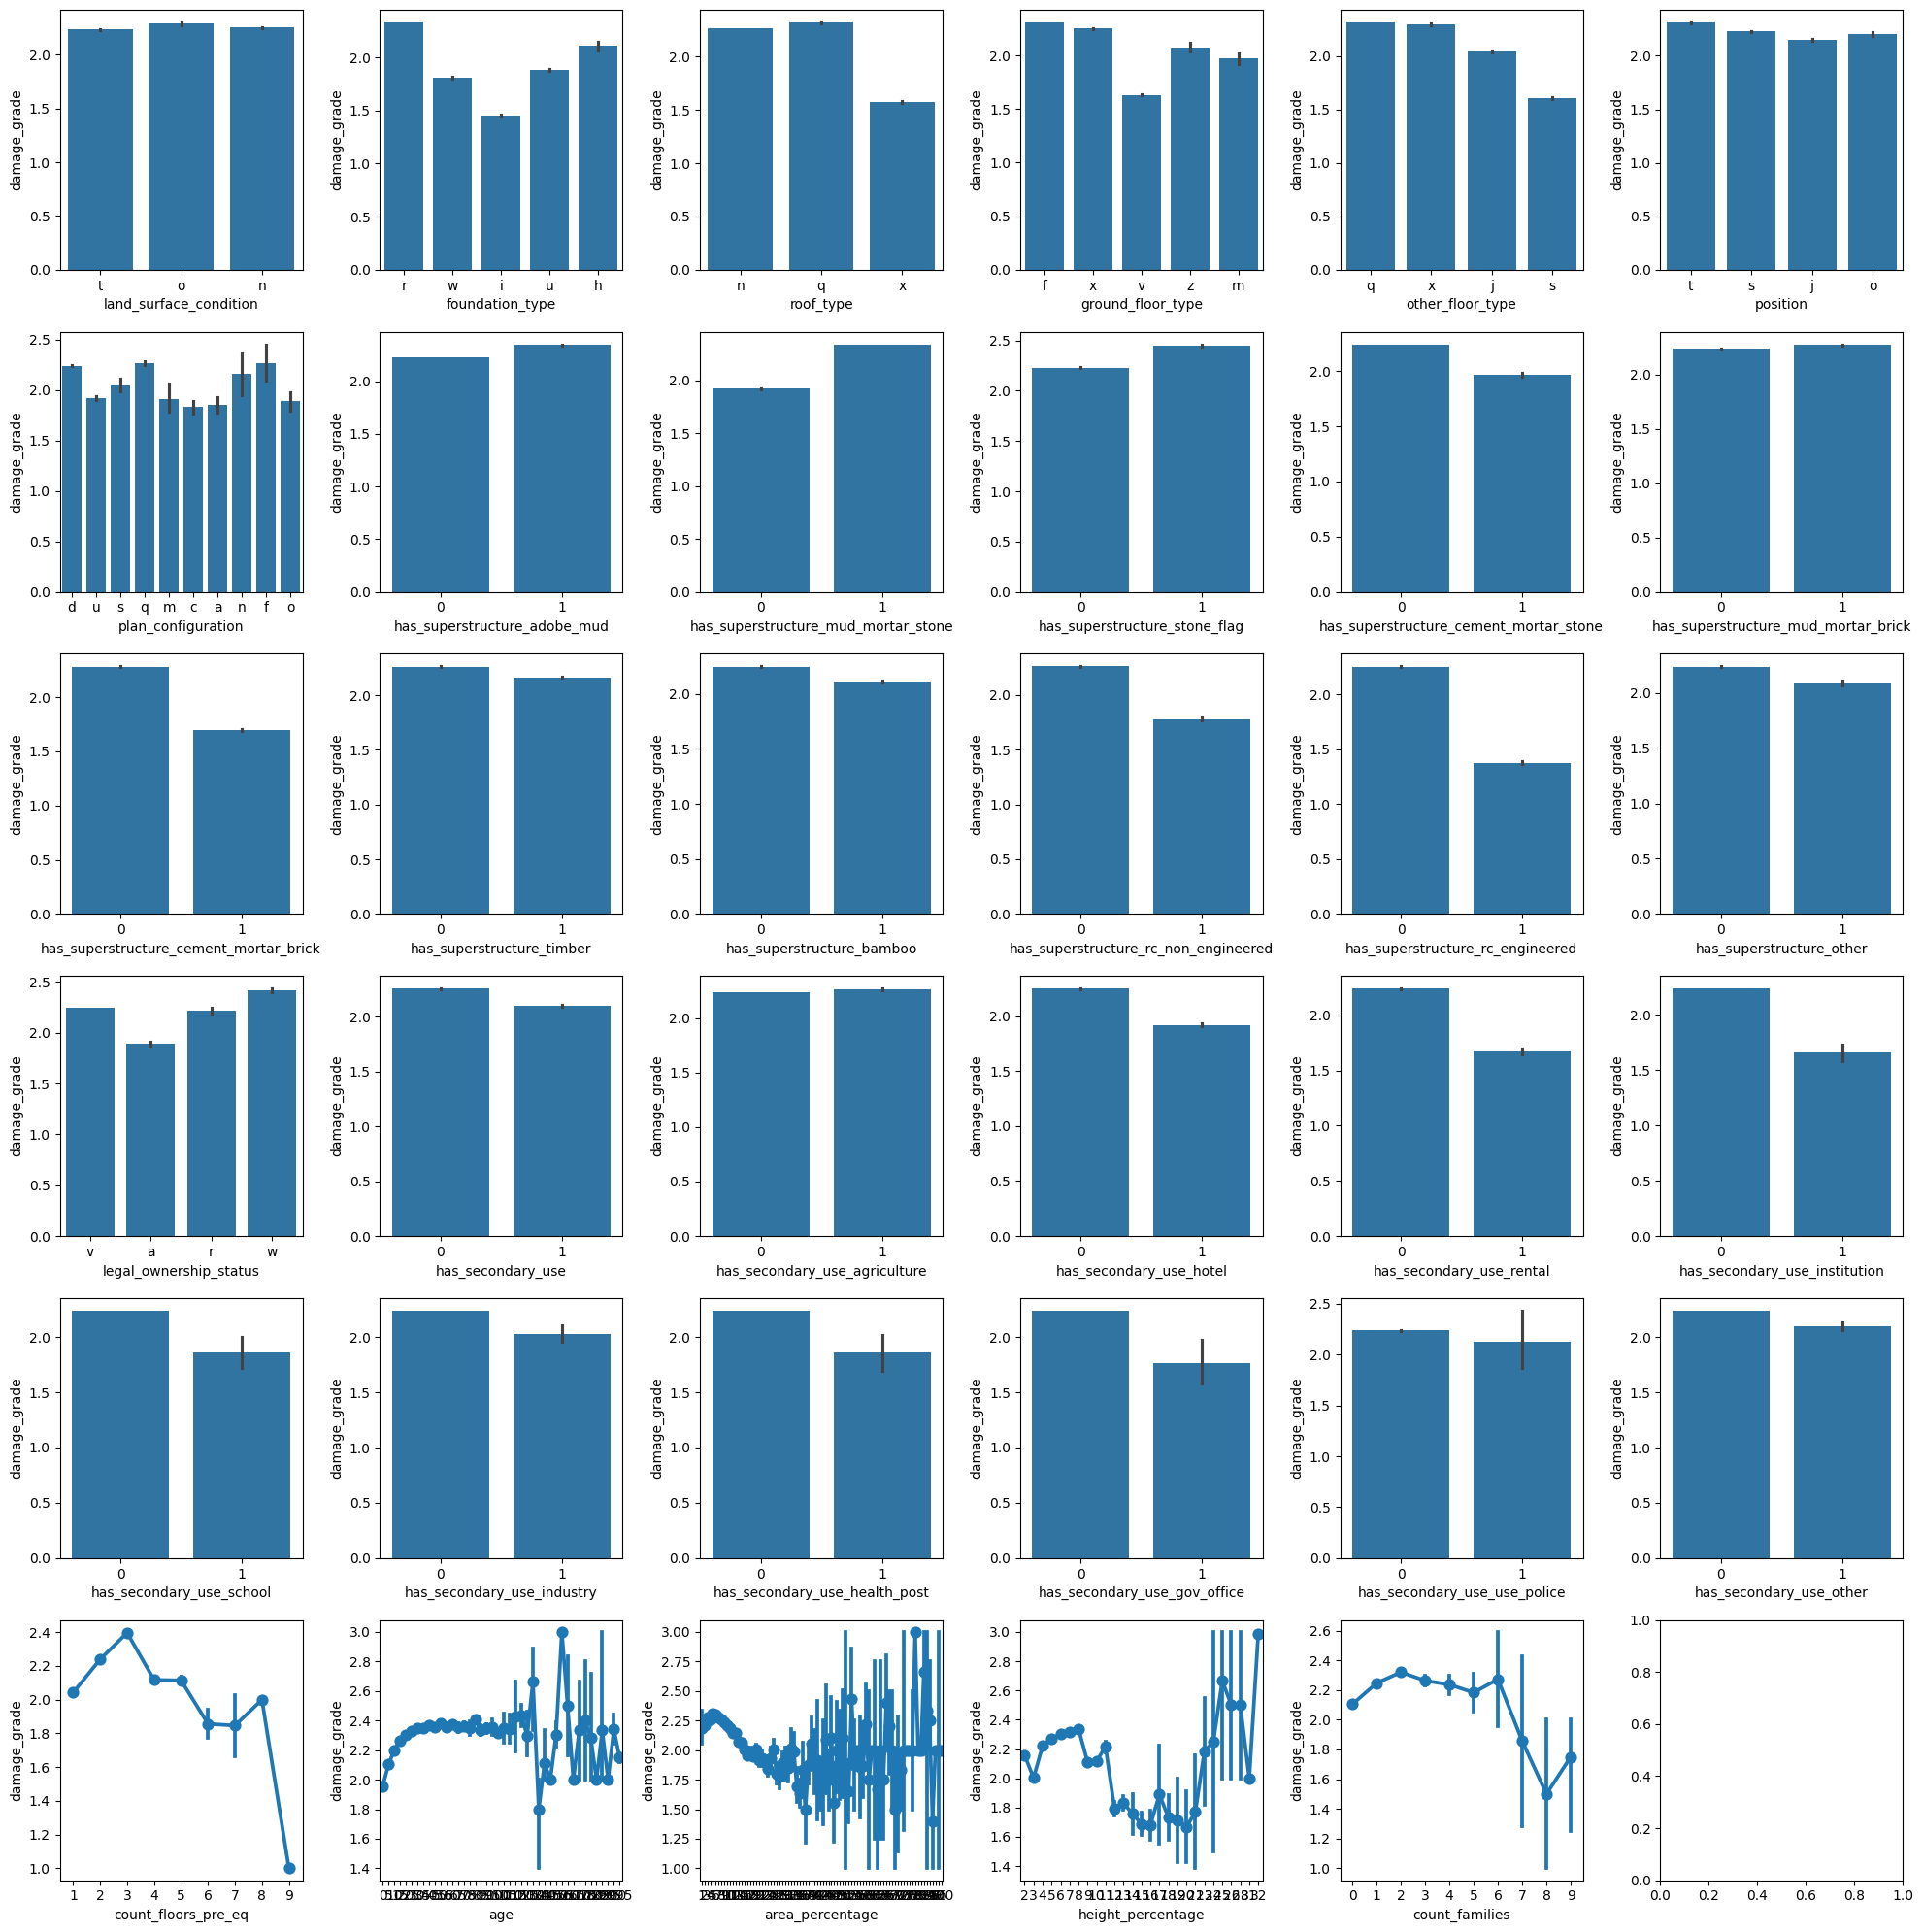

In [3]:
df_train_features = df_train_features_raw.copy()
df_train_labels = df_train_labels_raw.copy()
df_train = pd.concat([df_train_features,df_train_labels],axis=1)
non_geo_features = list(df_train.columns)
non_geo_features = [feat for feat in non_geo_features if not (feat in geo_features+['damage_grade'])]
non_geo_features_cat = [feat for feat in non_geo_features if not (feat in numerical_features)]
non_geo_features_num = numerical_features

fig,axs = plt.subplots(6,6,figsize=(20,20))
axs = axs.flatten()

for i,feat in enumerate(non_geo_features_cat):
    sns.barplot(df_train,x=feat,y='damage_grade',ax=axs[i])

for i,feat in enumerate(non_geo_features_num):
    sns.pointplot(df_train,x=feat,y='damage_grade',ax=axs[i+30])

fig.tight_layout()

## Helpers

In [4]:
def preprocess(df_features:pd.DataFrame)->pd.DataFrame:
    # Convert numeric features to float for automatic handling by some GBM packages
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

## AutoEncoding Geographical Features

An auto-encoder network is deployed to uncover latent relationships between the different geographical locations at the same level, i.e. within `geo_level_1_id`, `geo_level_2_id` and `geo_level_3_id`. The model is trained on both labels (i.e. `damage_grade`) and non-geographical features (e.g. `age`, `roof_type`, `has_superstructure_timber` etc). The idea is that locations that are nearer to each other should experience similar damage levels and show similar construction characteristics. As such, the entire dataset (including prediction set) are employed in training the autoencoder. Missing labels, e.g. from the prediction dataset or withheld test set labels, are first imputed using the `impute_damage_grade` function given below. The imputation is done using mean values from other rows with the same geographical features. The resulting latent values replace the original geographical features.

In [5]:
def impute_damage_grade(df_train_X: pd.DataFrame,df_val_X: pd.DataFrame,
                        df_test_X: pd.DataFrame,df_pred_X: pd.DataFrame,
                        df_train_y: pd.DataFrame, df_val_y: Optional[pd.DataFrame]=None,
                        df_test_y: Optional[pd.DataFrame]=None,
                        df_pred_y: Optional[pd.DataFrame]=None) -> pd.DataFrame:
    '''
    Impute damage grade based on location (i.e. the three geo-features). This imputation is done to provide
    values for later geo-encoding. Buildings without damage grades are imputed with mean values of other
    buildings in the same geographical locations. If such values are unavailable, the mean values of the
    higher geographical feature is taken.
    
    The original labelled dataset should first be split into train, val, and test sets. The pred set
    refers to the unlabelled dataset meant for later prediction and submission.The imputation will be
    done using all features from all datasets, but only labels from the dataset(s) meant for training,
    and could include both the train and val datasets. At prediction, all labels (including those from
    test set) are used. Supply as many label sets as required.
    
    df_train_X: Train features assuming labelled dataset is split into train-val-test sets
    df_val_X: Validation features assuming labelled dataset is split into train-val-test sets
    df_test_X: Test features assuming labelled dataset is split into train-val-test sets
    df_pred_X: Prediction features from unlabelled dataset
    df_train_y: Train labels assuming labelled dataset is split into train-val-test sets
    df_val_y: Validation labels assuming labelled dataset is split into train-val-test sets
    df_test_y: Test labels assuming labelled dataset is split into train-val-test sets
    df_pred_y: Prediction labels predicted from first iteration model, for pseudo-labelling if needed
    '''
    
    # Preprocess to convert numerical features to float
    df_train_X = preprocess(df_train_X.copy())
    df_val_X = preprocess(df_val_X.copy())
    df_test_X = preprocess(df_test_X.copy())
    df_pred_X = preprocess(df_pred_X.copy())
    df_all = pd.concat([df_train_X,df_train_y],axis=1)

    # Include all labels involved in imputation
    if df_val_y is not None:
        df_val_X = pd.concat([df_val_X,df_val_y],axis=1)
    if df_test_y is not None:
        df_test_X = pd.concat([df_test_X,df_test_y],axis=1)
    if df_pred_y is not None:
        df_pred_X = pd.concat([df_pred_X,df_pred_y],axis=1)
    df_all = pd.concat([df_all,df_val_X,df_test_X,df_pred_X],axis=0)

    # Imputing from the bottom geographical feature up.
    if (df_val_y is None) or (df_test_y is None) or (df_pred_y is None):
        df_all['geo_combined3'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']) + '_' + str(row['geo_level_3_id']), axis=1)
        df_all['geo_combined2'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']), axis=1)

        # Fillna for damage_grade with means for geo level 3
        damage_means3 = df_all.groupby('geo_combined3')['damage_grade'].mean()
        df_all['damage_grade'] = df_all.apply(lambda row: damage_means3[row['geo_combined3']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

        # Fillna for damage_grade with means for lowest geo level 2
        damage_means2 = df_all.groupby('geo_combined2')['damage_grade'].mean()
        df_all['damage_grade'] = df_all.apply(lambda row: damage_means2[row['geo_combined2']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

        # Fillna for damage_grade with means for lowest geo level 2
        damage_means1 = df_all.groupby('geo_level_1_id')['damage_grade'].mean()
        df_all['damage_grade'] = df_all.apply(lambda row: damage_means1[row['geo_level_1_id']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

        # Drop unwanted columns and OHE.
        df_all.drop(columns=['geo_combined2','geo_combined3'],inplace=True)

    # OHE needed for auto-encoder network.
    df_all = pd.get_dummies(df_all,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)

    # Get feature names
    non_geo_features_OHE = [col for col in df_all.columns if not (col in geo_features)]

    return df_all, non_geo_features_OHE

After imputation, the dataset is fed into an autoencoder for training. The network is given by the `CategoricalAutoencoder` class below.

In [6]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    # AutoEncoder network to produce latent encodings for the geographical features in the earthquake dataset.
    def __init__(self, geo1_size, geo2_size, geo3_size, inter_size, latent_size):
        super(CategoricalAutoencoder, self).__init__()
        self.geo1_size = geo1_size
        self.geo2_size = geo2_size
        self.geo3_size = geo3_size

        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, geo1_size)
        self.embed2 = nn.Embedding(1418, geo2_size)
        self.embed3 = nn.Embedding(11861, geo3_size)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(geo1_size + geo2_size + geo3_size + 58, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, geo1_size + geo2_size + geo3_size + 58)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(geo1_size, 31)
        self.output2 = nn.Linear(geo2_size, 1418)
        self.output3 = nn.Linear(geo3_size, 11861)
        
    def forward(self, x1, x2, x3, feats):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3, feats], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [self.geo1_size, self.geo2_size, self.geo3_size, 58], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out, feats_recon

After training, the original dataset is fed through the encoder to produce the latent encoding. For simplicity, the latent encoding for each location represented by the original geographical features is simply taken as the mean value. The steps for producing `latent_geo`, the mapping between the original geographical features and their correspoding latent encoding, are carried out in the `get_latent_geo` function below.

In [7]:
def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    latent_size: Dimension of latent variables
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model for
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute the loss
            loss = (criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch))
            
            loss_feat = nn.MSELoss()(feats_recon, feats_batch)

            total_loss = loss + loss_feat

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3

## CatBoost Classifier

### Vanilla CatBoost - no geo-encoding

As a baseline for comparison with later models, we fit a vanilla CatBoost model with no geo-encoding. The hyperparameters are chosen based on cross-validation not shown in this notebook.

In [8]:
# Prep data for catboost vanilla
df_train_features = preprocess(df_train_features_raw)                   # Convert numeric features to float
X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
 
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_val_dataset = cb.Pool(data=pd.concat([X_train,X_val],axis=0),
                            label=pd.concat([y_train,y_val],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    grow_policy='Depthwise', # Tree growth policy
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

0:	learn: 1.0905119	total: 54.3ms	remaining: 18m 5s
5000:	learn: 0.5528504	total: 29.3s	remaining: 1m 27s
10000:	learn: 0.5170208	total: 1m	remaining: 1m
15000:	learn: 0.4866375	total: 1m 32s	remaining: 30.8s
19999:	learn: 0.4598977	total: 2m 5s	remaining: 0us
Testing performance
Accuracy: 0.7501
F1-score: 0.7501


### Catboost with geo-encoding

Next, we perform the same fitting with geo-encoding, i.e. using latent values obtained from the encoder. Note that the labels for the test set is not provided, and is instead imputed alongside the labels for the prediction set in the `impute_damage_grade` function. The `get_geo_encoded_dataset` function produces the final geo-encoded datasets.

In [9]:
def get_geo_encoded_dataset(epochs: int=10, train_on: str='train_val'):
    '''
    Produce geo-encoded train, val, test, and pred datasets.
    epochs: Number of epochs to train auto-encoder
    train_on: 'train_val' to train on train and val datasets, for prediction on test set. 'train_val_test' to train on train, val and test datasets, for prediction on pred set for submission.
    '''
    # Shared latent geo for all models
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X_or = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    if train_on == 'train_val':
        df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, 
                                                        df_test_X_or,df_pred_X_or, 
                                                        df_train_y_or,df_val_y_or)
    elif train_on == 'train_val_test':
        df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, 
                                                        df_test_X_or,df_pred_X_or, 
                                                        df_train_y_or,df_val_y_or,
                                                        df_test_y_or)
    else:
        raise Exception('Unknown model training requirement for CatBoost classifier model.')

    # Set up architecture
    geo1_size = 16
    geo2_size = 32
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = epochs

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature names and convert to category
    categorical_feature_names = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_feature_names.append(feat)
    
    df_train_X[categorical_feature_names] = df_train_X[categorical_feature_names].astype('category')
    df_val_X[categorical_feature_names] = df_val_X[categorical_feature_names].astype('category')
    df_test_X[categorical_feature_names] = df_test_X[categorical_feature_names].astype('category')
    df_pred_X[categorical_feature_names] = df_pred_X[categorical_feature_names].astype('category')

    return df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or


Note that the hyperparameters for the CatBoost classifier model as well as the architecture of the autoencoder are selected using a simple grid search (not presented here). The pipeline for CatBoost model training and prediction is performed by the `train_and_pred_catboost` function.

In [10]:
def train_and_pred_catboost(df_train_X:pd.DataFrame, df_val_X:pd.DataFrame,
                            df_test_X:pd.DataFrame, df_pred_X:pd.DataFrame,
                            df_train_y_or:pd.DataFrame, df_val_y_or:pd.DataFrame,
                            df_test_y_or:pd.DataFrame,train_on: str='train_val',
                            pred_on:str='test',depth:int=8):
    '''
    Train CatBoost classifier model and predict on test/pred set.
    df_train_X: Dataframe of train features
    df_val_X: Dataframe of val features
    df_test_X: Dataframe of test features
    df_pred_X: Dataframe of pred features
    df_train_y_or: Dataframe of train labels
    df_val_y_or: Dataframe of val labels
    df_test_y_or: Dataframe of test labels
    train_on: 'train_val' to train on train and val datasets, for prediction on test set. 'train_val_test' to train on train, val and test datasets, for prediction on pred set for submission.
    pred_on: 'test' to predict on test set and perform evaluation. 'pred' to oredict on pred set for submission
    depth: Tree depth for catboost model
    '''
    # Train catboost
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    # train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
    # val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
    # test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=depth,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        grow_policy='Depthwise',
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    # Train model
    if train_on == 'train_val':
        model_cls.fit(train_val_dataset)
    elif train_on == 'train_val_test':
        model_cls.fit(train_val_test_dataset)
    else:
        Exception('Unknown model training requirement for CatBoost classifier model.')


    # Prediction/Evaluation
    if pred_on == 'test':            # Prediction on test set and F1-score evaluation
        pred_cls = model_cls.predict(df_test_X)
        f1 = f1_score(df_test_y_or,pred_cls,average='micro')
        print('Testing performance')
        print(f'F1-score: {f1:.4f}')
    elif pred_on == 'pred':          # Prediction on pred set for submission
        pred_cls = model_cls.predict(df_pred_X)
    else:
        raise Exception('Unknown prediction requirement for CatBoost classifier model.')
    
    return pred_cls


Getting geo-encoded features, training CatBoost model and evaluating on test set.

In [11]:
df_train_X, df_val_X, df_test_X, \
    df_pred_X, df_train_y_or, df_val_y_or, \
        df_test_y_or = get_geo_encoded_dataset(epochs=10, train_on='train_val')

_ = train_and_pred_catboost(df_train_X, df_val_X, df_test_X, df_pred_X,
                            df_train_y_or, df_val_y_or, df_test_y_or,
                            train_on='train_val', pred_on='test',depth=8)

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 489.71it/s]


Epoch [1/10], Loss: 8.408948262239942


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 547.43it/s]


Epoch [2/10], Loss: 0.5636999990697813


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 526.27it/s]


Epoch [3/10], Loss: 0.30567922804158987


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 553.44it/s]


Epoch [4/10], Loss: 0.24364082730856665


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 540.41it/s]


Epoch [5/10], Loss: 0.19085437361979432


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 544.42it/s]


Epoch [6/10], Loss: 0.17241990533335044


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 536.67it/s]


Epoch [7/10], Loss: 0.1448616612461205


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 555.46it/s]


Epoch [8/10], Loss: 0.12691387913802937


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 541.20it/s]


Epoch [9/10], Loss: 0.12580929524834447


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 563.23it/s]


Epoch [10/10], Loss: 0.10154238214033254


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1391.85it/s]


0:	learn: 1.0920894	total: 9.5ms	remaining: 3m 10s
5000:	learn: 0.4913760	total: 39.6s	remaining: 1m 58s
10000:	learn: 0.4517273	total: 1m 18s	remaining: 1m 18s
15000:	learn: 0.4237644	total: 1m 56s	remaining: 38.9s
19999:	learn: 0.4013167	total: 2m 35s	remaining: 0us
Testing performance
F1-score: 0.7564


As shown above, the geo_encoded model performs better, achieving a higher F1-score.

## XGBoost

While CatBoost is traditionally used for datasets with a large number of categorical features, newer versions of XGBoost can now also handle categorical features natively. We perform a similar modelling and evaluation below. The geo-encoded features from the previous section is reused here. The relevant XGBoost hyperparameters are similarly obtained from grid search. The pipeline for CatBoost model training and prediction is performed by the `train_and_pred_xgboost` function.

In [12]:
def train_and_pred_xgboost(df_train_X:pd.DataFrame, df_val_X:pd.DataFrame,
                            df_test_X:pd.DataFrame, df_pred_X:pd.DataFrame,
                            df_train_y_or:pd.DataFrame, df_val_y_or:pd.DataFrame,
                            df_test_y_or:pd.DataFrame,train_on: str='train_val',
                            pred_on:str='test',learning_rate:float=0.1):
    '''
    Train XGBoost classifier model and predict on test/pred set.
    df_train_X: Dataframe of train features
    df_val_X: Dataframe of val features
    df_test_X: Dataframe of test features
    df_pred_X: Dataframe of pred features
    df_train_y_or: Dataframe of train labels
    df_val_y_or: Dataframe of val labels
    df_test_y_or: Dataframe of test labels
    train_on: 'train_val' to train on train and val datasets, for prediction on test set. 'train_val_test' to train on train, val and test datasets, for prediction on pred set for submission.
    pred_on: 'test' to predict on test set and perform evaluation. 'pred' to oredict on pred set for submission
    learning_rate: Learning rate for XGBoost classifier
    '''

    # Supported tree methods are `approx` and `hist`.
    model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                                learning_rate=learning_rate,n_estimators=1000,
                                subsample=1,colsample_bytree=0.8,gamma=0.2)

    # Train model
    if train_on == 'train_val':
        model_xgb.fit(pd.concat([df_train_X,df_val_X],axis=0),
                      pd.concat([df_train_y_or-1, df_val_y_or-1],axis=0))
    elif train_on == 'train_val_test':
        model_xgb.fit(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                    pd.concat([df_train_y_or-1, df_val_y_or-1,df_test_y_or-1],axis=0))
    else:
        Exception('Unknown model training requirement for XGBoost classifier model.')


    # Prediction/Evaluation
    if pred_on == 'test':            # Prediction on test set and F1-score evaluation
        model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
        pred_xgb = model_xgb.predict(df_test_X)+1
        f1 = f1_score(df_test_y_or,pred_xgb,average='micro')
        print('Testing performance')
        print(f'F1-score: {f1:.4f}')
    elif pred_on == 'pred':          # Prediction on pred set for submission
        model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
        pred_xgb = model_xgb.predict(df_pred_X)+1
    else:
        raise Exception('Unknown prediction requirement for XGBoost classifier model.')
    
    return pred_xgb

In [13]:
df_train_X, df_val_X, df_test_X, \
    df_pred_X, df_train_y_or, df_val_y_or, \
        df_test_y_or = get_geo_encoded_dataset(epochs=10, train_on='train_val')

_ = train_and_pred_xgboost(df_train_X, df_val_X, df_test_X, df_pred_X,
                            df_train_y_or, df_val_y_or, df_test_y_or,
                            train_on='train_val', pred_on='test',learning_rate=0.1)

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 538.03it/s]


Epoch [1/10], Loss: 8.596923760312647


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 508.39it/s]


Epoch [2/10], Loss: 0.6282348591773956


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 520.88it/s]


Epoch [3/10], Loss: 0.317640647089139


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 528.92it/s]


Epoch [4/10], Loss: 0.30123969192159894


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 540.45it/s]


Epoch [5/10], Loss: 0.2325572419873218


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 527.31it/s]


Epoch [6/10], Loss: 0.15618687864552103


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 543.53it/s]


Epoch [7/10], Loss: 0.1615509579290083


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 529.96it/s]


Epoch [8/10], Loss: 0.1480689666731851


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 522.82it/s]


Epoch [9/10], Loss: 0.13290161031006187


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 532.15it/s]


Epoch [10/10], Loss: 0.13217944536901274


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1378.66it/s]


Testing performance
F1-score: 0.7553


XGBoost shows a similar performance as compared to CatBoost.

## LightGBM

Finally, LighGBM is trained, completing the trio. The pipeline for LightGBM model training and prediction is performed by the `train_and_pred_lgbm` function.

In [14]:
def train_and_pred_lgbm(df_train_X:pd.DataFrame, df_val_X:pd.DataFrame,
                            df_test_X:pd.DataFrame, df_pred_X:pd.DataFrame,
                            df_train_y_or:pd.DataFrame, df_val_y_or:pd.DataFrame,
                            df_test_y_or:pd.DataFrame,train_on: str='train_val',
                            pred_on:str='test',depth:int=8):
    '''
    Train LightGBM classifier model and predict on test/pred set.
    df_train_X: Dataframe of train features
    df_val_X: Dataframe of val features
    df_test_X: Dataframe of test features
    df_pred_X: Dataframe of pred features
    df_train_y_or: Dataframe of train labels
    df_val_y_or: Dataframe of val labels
    df_test_y_or: Dataframe of test labels
    train_on: 'train_val' to train on train and val datasets, for prediction on test set. 'train_val_test' to train on train, val and test datasets, for prediction on pred set for submission.
    pred_on: 'test' to predict on test set and perform evaluation. 'pred' to oredict on pred set for submission
    depth: Tree depth for LightGBM model
    '''
    # Train lightgbm
    categorical_features_lgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_lgb.append(feat)

    train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                                categorical_feature=categorical_features_lgb)
    train_val_test_data = lgb.Dataset(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
    test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                            categorical_feature=categorical_features_lgb,
                            reference=train_val_data)

    # Define model parameters
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 80,
        'max_depth': 8,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'device':'gpu'
    }

    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

    # Train model
    if train_on == 'train_val':
        model_lgb = lgb.train(
            params,
            train_val_data,
            valid_sets=[train_val_data, test_data],
            valid_names=['train', 'valid'],
            num_boost_round=1500,
            callbacks=callbacks
            )
    elif train_on == 'train_val_test':
        model_lgb = lgb.train(
            params,
            train_val_test_data,
            valid_sets=[train_val_test_data, test_data],
            valid_names=['train', 'valid'],
            num_boost_round=1500,
            callbacks=callbacks
        )
    else:
        Exception('Unknown model training requirement for LightGBM classifier model.')

    # Prediction/Evaluation
    if pred_on == 'test':            # Prediction on test set and F1-score evaluation
        pred_lgb = model_lgb.predict(df_test_X, num_iteration=model_lgb.best_iteration)
        pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification
        f1 = f1_score(df_test_y_or,pred_lgb,average='micro')
        print('Testing performance')
        print(f'F1-score: {f1:.4f}')
    elif pred_on == 'pred':          # Prediction on pred set for submission
        pred_lgb = model_lgb.predict(df_pred_X, num_iteration=model_lgb.best_iteration)
        pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification
    else:
        raise Exception('Unknown prediction requirement for LightGBM classifier model.')
    
    return pred_lgb


In [15]:
df_train_X, df_val_X, df_test_X, \
    df_pred_X, df_train_y_or, df_val_y_or, \
        df_test_y_or = get_geo_encoded_dataset(epochs=10, train_on='train_val')

_ = train_and_pred_lgbm(df_train_X, df_val_X, df_test_X, df_pred_X,
                            df_train_y_or, df_val_y_or, df_test_y_or,
                            train_on='train_val', pred_on='test',depth=8)

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 539.68it/s]


Epoch [1/10], Loss: 8.900628457364348


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 516.51it/s]


Epoch [2/10], Loss: 0.5700744495388335


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 529.12it/s]


Epoch [3/10], Loss: 0.3284562080604777


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 523.03it/s]


Epoch [4/10], Loss: 0.2633445949097533


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 523.76it/s]


Epoch [5/10], Loss: 0.2271750289562744


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 533.99it/s]


Epoch [6/10], Loss: 0.17220129732958786


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 543.41it/s]


Epoch [7/10], Loss: 0.14589809764873385


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 536.61it/s]


Epoch [8/10], Loss: 0.14164342920519465


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 530.20it/s]


Epoch [9/10], Loss: 0.12661232088523777


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 517.96it/s]


Epoch [10/10], Loss: 0.1125561005856968


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1445.24it/s]


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[838]	train's multi_logloss: 0.43635	valid's multi_logloss: 0.549926
Testing performance
F1-score: 0.7561


LightGBM shows a similar performance as compared to CatBoost and XGBoost.

## Ensemble

Here, we perform model ensembling with multiple variants of the CatBoost, XGBoost, and LightGBM models, with some perturbations introduced to the different variants. We take advantage of the randomness introduced by the AutoEncoder network built in pytorch to inject some perturbation to the different variants.

In [16]:
preds_cls = []
preds_xgb = []
preds_lgb = []

for i in range(10):
    # Get geo-encoded datasets
    df_train_X, df_val_X, df_test_X, \
        df_pred_X, df_train_y_or, df_val_y_or, \
            df_test_y_or = get_geo_encoded_dataset(epochs=10, train_on='train_val')
    
    preds_cls.append(train_and_pred_catboost(df_train_X, df_val_X, df_test_X, df_pred_X,
                                             df_train_y_or, df_val_y_or, df_test_y_or,
                                             train_on='train_val', pred_on='test',depth=8))
    preds_xgb.append(train_and_pred_xgboost(df_train_X, df_val_X, df_test_X, df_pred_X,
                                            df_train_y_or, df_val_y_or, df_test_y_or,
                                            train_on='train_val', pred_on='test',learning_rate=0.1))
    preds_lgb.append(train_and_pred_lgbm(df_train_X, df_val_X, df_test_X, df_pred_X,
                                         df_train_y_or, df_val_y_or, df_test_y_or,
                                         train_on='train_val', pred_on='test',depth=8))

In [17]:
# Combine predictions for each GBM (10 trials each)
df_preds_cls = pd.concat([pd.DataFrame(arr) for arr in preds_cls],axis=1)
df_preds_xgb = pd.concat([pd.DataFrame(arr) for arr in preds_xgb],axis=1)
df_preds_lgb = pd.concat([pd.DataFrame(arr) for arr in preds_lgb],axis=1)

# # Export to csv
# df_preds_cls.to_csv('cls.csv')
# df_preds_xgb.to_csv('xgb.csv')
# df_preds_lgb.to_csv('lgb.csv')

In [18]:
# # Load from csv
# df_preds_cls = pd.read_csv('cls.csv').drop(columns='Unnamed: 0')
# df_preds_xgb = pd.read_csv('xgb.csv').drop(columns='Unnamed: 0')
# df_preds_lgb = pd.read_csv('lgb.csv').drop(columns='Unnamed: 0')

# Voting system for ensemble predictions
cls_ens = df_preds_cls.mode(axis=1).iloc[:,0]
xgb_ens = df_preds_xgb.mode(axis=1).iloc[:,0]
lgb_ens = df_preds_lgb.mode(axis=1).iloc[:,0]
all_ens = pd.concat([df_preds_cls,df_preds_xgb,df_preds_lgb],axis=1).mode(axis=1).iloc[:,0]

# Evaluate with F1-score
f1_cls = f1_score(df_test_y_or,cls_ens,average='micro')
f1_xgb = f1_score(df_test_y_or,xgb_ens,average='micro')
f1_lgb = f1_score(df_test_y_or,lgb_ens,average='micro')
f1_all = f1_score(df_test_y_or,all_ens,average='micro')
print(f'F1-score (CatBoost): {f1_cls}')
print(f'F1-score (XGBoost): {f1_xgb}')
print(f'F1-score (LightGBM): {f1_lgb}')
print(f'F1-score (Ensemble): {f1_all}')

F1-score (CatBoost): 0.7568238213399504
F1-score (XGBoost): 0.7571307973702387
F1-score (LightGBM): 0.7572587040495254
F1-score (Ensemble): 0.7580005627893889


As shown, the F1-score of the ensemble model involving all three GBM models outperforms the ones involving individual models only.

## Submission File

Based on the findings above, we perform a **crude** ensembling here, with multiple predictions from the same models trained with some perturbation, either introduced by the autoencoder between runs, or in model parameters like learning rates or tree depths.

In [19]:
# All combos of hyperparameters to consider for producing perturbed models
all_epochs = [10,9,9,11,11]
all_cls_depths = [8,7,7,9,9]
all_xgb_learning_rates = [0.1,0.08,0.08,0.12,0.12]
all_lgb_depths = [8,7,7,9,9]

preds = []
for i in range(5):
    print(f'\n\n ~~~~~~~~~~~ Gathering predictions for combo {i} ~~~~~~~~~~~')
    epochs = all_epochs[i]
    cls_depth = all_cls_depths[i]
    xgb_lr = all_xgb_learning_rates[i]
    lgb_depth = all_lgb_depths[i]
    
    for j in range(200):
        df_train_X, df_val_X, df_test_X, \
            df_pred_X, df_train_y_or, df_val_y_or, \
                df_test_y_or = get_geo_encoded_dataset(epochs=epochs, train_on='train_val')
        preds.append(train_and_pred_catboost(df_train_X, df_val_X, df_test_X, df_pred_X,
                                             df_train_y_or, df_val_y_or, df_test_y_or,
                                             train_on='train_val', pred_on='test',depth=cls_depth))
        preds.append(train_and_pred_xgboost(df_train_X, df_val_X, df_test_X, df_pred_X,
                                            df_train_y_or, df_val_y_or, df_test_y_or,
                                            train_on='train_val', pred_on='test',learning_rate=xgb_lr))
        preds.append(train_and_pred_lgbm(df_train_X, df_val_X, df_test_X, df_pred_X,
                                         df_train_y_or, df_val_y_or, df_test_y_or,
                                         train_on='train_val', pred_on='test',depth=lgb_depth))

# Create dataframe from predictions
df_preds = pd.DataFrame(preds).T
# filename = f'all_preds.csv'
# df_preds.to_csv(filename,index=None)

# Prep for CSV submission
df_preds['pred'] = df_preds.mode(axis=1).iloc[:,0].astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = df_preds['pred']
df_sub.to_csv('dd_earthquake_submission.csv',index=False)

## Conclusion and Future Work

This notebooks details the strategy used to predict earthquake damage given housing features.

1. **GBM Ensemble** - The current approach uses three popular GBMs, including CatBoost, XGBoost, and LightGBM. While each performs reasonably well on its own, the ensemble prediction involving all three GBMs demonstrates superior predictive power, as shown below. This improved performance is observed even though bulk of the models are produced from simple perturbation, which is crude but implementationally straightforward;

    <img src=".\assets\f1_distribution.png" alt="F1-scores of Various Models" width="800"/>

2. **Auto-encoder** - The strategy detailed here also includes an auto-encoder to capture geographic details using other features as well as the label in the dataset. This approach appears to have improved CatBoost model performance significantly, at least compared to the [vanilla approach](#Vanilla-CatBoost---no-geo-encoding), where high cardinal geographic features are simply target encoded.

As future work, I would like to explore using:
1. more advanced geo-encoding approaches, e.g. **TorchGeo**, to better extract geography related features.
2. **ordinal regression** approaches, which was briefly explored using [OrdinalGBT](https://ordinalgbt.readthedocs.io/en/latest/) but produced odd results. It is noted here that the regression variants of the GBMs considered here were also explored at an early stage, but produced inferior results compared to the classifier variants;
3. **stacked ensemble** approaches.